Python Workshop 2: economic simulations and web scraping

https://colab.research.google.com/

In [1]:
# Import libraries
# import [library] as [alias]
import requests, bs4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Monte Carlo economic simulation.

https://en.wikipedia.org/wiki/Monte_Carlo_method

In [2]:
class LettuceFarm:
    # This is our class's Docstring
    '''
    Welcome to your lettuce farm!
    
    To start a farm, you need to have some initial amount of cash (initial_cash_100k), 
    some of which may be made up of loans you take out (loan_amount_100k). These loans
    are paid back over 15 years with interest (interest_rate). 
    
    To start your farm, you need to pay a one-time initial investment (initial_investment_100k). 
    The cash you have remaining (initial_cash_100k - initial_investment_100k) is then used to grow
    lettuce in your first year — it covers all costs, e.g., wages, seed, tractor fuel, etc.
    
    Each year you dedicate 2/3 of your cash to a lettuce_budget for planting lettuce, 
    and you keep the remaining 1/3 on hand to cover yourself if you have negative profits. 
    Your production function for your average amount of lettuce grown is given by: 
        A * (lettuce_budget^0.1) * (rain^0.2),
    where A is the productivity of your farm (productivity) and rain is i.i.d. and drawn from a 
    normal distribution. The result of this production function is then the average value of a
    poisson distribution, from which the actual amount of lettuce produced is drawn. 
    Additionally, there is a 1/100 chance that there is an extreme weather event (e.g., drought) 
    that cuts your lettuce production for a year by 90 percent.
    
    Each year, average demand is determined by the price of lettuce and some elasticity of demand. 
    Consumers are price takers; price is determined by the market. So price is i.i.d. and drawn
    from a normal distribution. Similarly, price_elasticity is i.i.d and drawn from a normal
    distribution. The average demand is then the average value of a poisson distribution, from
    which the actual amount of lettuce demanded is drawn. 
    Additionally, there is a 1/50 chance that there is an event that greatly diminishes lettuce
    demand in a given year (e.g., E. coli "incident").
    
    We determine profits by netting the amount by which the lettuce farm brings in revenue less
    the amount it dedicated to its lettuce_budget plus loan repayment costs. If profits are negative,
    cash reserves must be used to cover the difference. If the amount of cash becomes negative (or 
    implausible values are given as parameters), our firm goes bankrupt due to inadequate funds (or 
    "mismanagement") and then reports 0 cash and 0 profits for all future years.
    
    Disclaimer: the parameters are all made up; don't use this as a tool to decide whether to start
    your own lettuce farm!
    '''
    
    def __init__(self, initial_cash_100k = 1.0, # starting cash on hand
                       initial_investment_100k = 0.75, # initial, one-time investment
                       loan_amount_100k = 0.3, # initial loan amount
                       productivity = 100.0, # production function productivity level
                       interest_rate = 0.05): # interest rate for loans
        self.cash = (initial_cash_100k - initial_investment_100k) * 100000
        self.A = productivity
        self.interest_rate = interest_rate
        loan = loan_amount_100k * 100000
        self.annual_loan_payments = [(loan / 15) + (loan * self.interest_rate)]
        self.loan_years_remaining = [15]
        self.loans_repaid = [years_remaining == 0 for years_remaining in self.loan_years_remaining]
        self.year = 0
        if loan_amount_100k > initial_cash_100k:
            raise Exception('The amount you have in cash must, by definition, exceed the amount of your loan.')
        if initial_investment_100k > initial_cash_100k:
            raise Exception('You can\'t invest more than the amount of cash you have.')
    
    # The __call__() method is accessed by typing just the name of the class object you've created (e.g., our_farm())
    def __call__(self):
        return f'This lettuce farm is {str(self.year)} years old.\nIt currently has ${str(round(self.cash,2))} in cash on hand.\n'
    
    # Writing __method() effectively "hides" the method when we create a new LettuceFarm object (i.e., we can't access the method)
    def __lettuce_produced(self):
        self.lettuce_budget = (2.0 / 3.0) * self.cash
        rain = np.random.normal(50,15)
        if np.random.random() < 0.01:
            rain /= 10
        mean_lettuce = self.A * (self.lettuce_budget ** 0.1) * (rain ** 0.2)
        lettuce = np.random.poisson(mean_lettuce)
        return lettuce
    
    def __lettuce_demanded(self):
        self.price = np.random.normal(40,5)
        price_elasticity = - np.random.normal(6,2)
        mean_lettuce = 1000 + (price_elasticity * self.price)
        lettuce = np.random.poisson(mean_lettuce)
        if np.random.random() < 0.02:
            return lettuce / 10
        else:
            return lettuce
    
    def __profit(self):
        supply = self.__lettuce_produced()
        demand = self.__lettuce_demanded()
        if supply <= demand:
            surplus = (supply * self.price) - self.lettuce_budget
        else:
            surplus = (demand * self.price) - self.lettuce_budget

        for (index, loan_repaid) in enumerate(self.loans_repaid):
            if not loan_repaid:
                surplus -= self.annual_loan_payments[index]
                if self.loan_years_remaining[index] > 0:
                    self.loan_years_remaining[index] -= 1
                    if self.loan_years_remaining[index] == 0:
                        self.loans_repaid[index] = True
        self.cash += surplus
        return surplus
    
    def new_loan(self, new_loan_amount_100k):
        loan = new_loan_amount_100k * 100000
        self.annual_loan_payments.append((loan / 15) + (loan * self.interest_rate))
        self.loan_years_remaining.append(15)
        self.cash += loan
        
    def add_year(self, new_loan_amount_100k = None, interest_rate = None):
        try:
            if interest_rate:
                self.interest_rate = interest_rate
            if new_loan_amount_100k:
                self.new_loan(new_loan_amount_100k)
            profit = self.__profit()
            self.year += 1
            return profit, self.cash, self.year

        except:
            self.year += 1
            return 0, 0, self.year
            # raise Exception('You\'re bankrupt!')

In [3]:
# Accessing the Docstring
LettuceFarm?

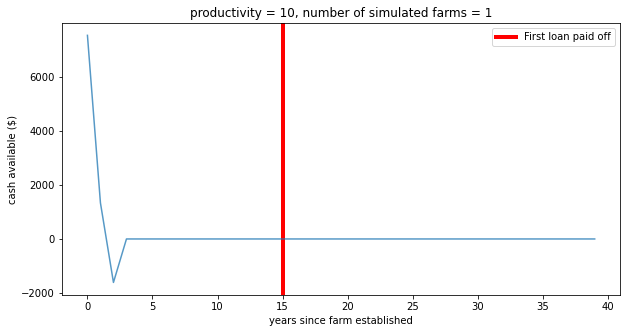

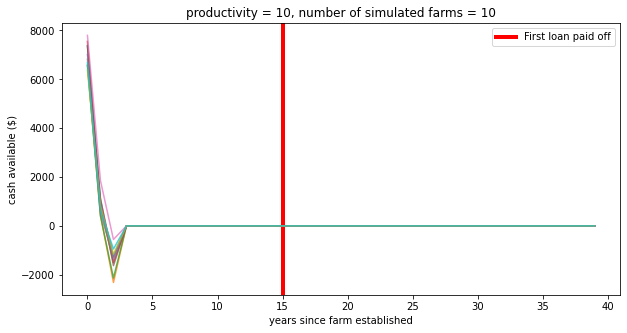

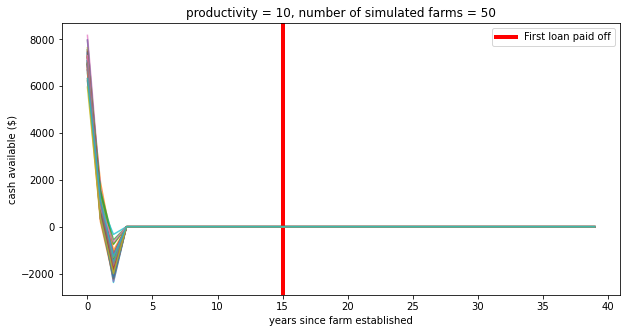

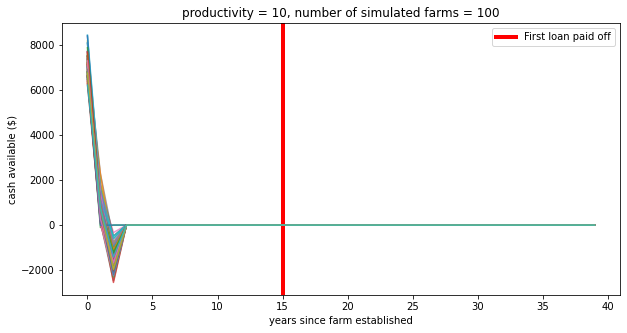

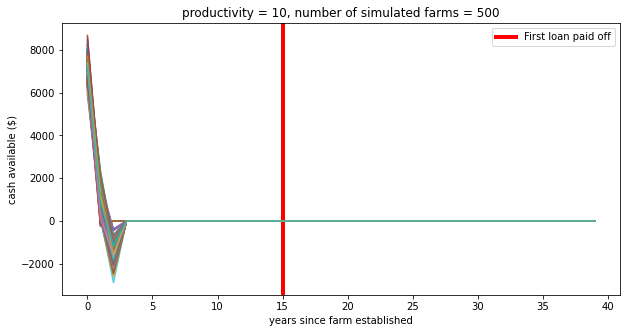

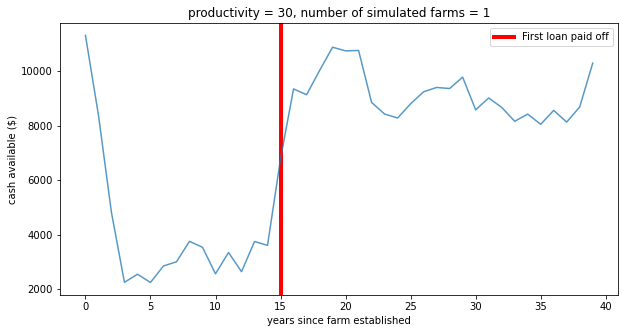

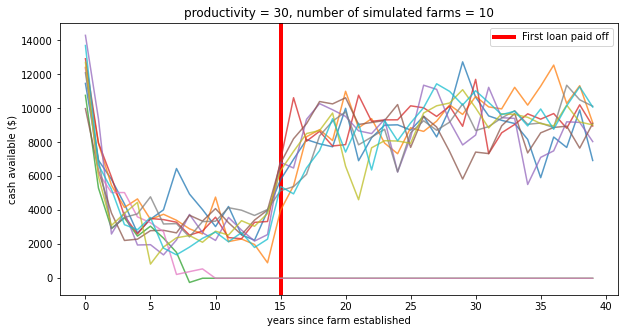

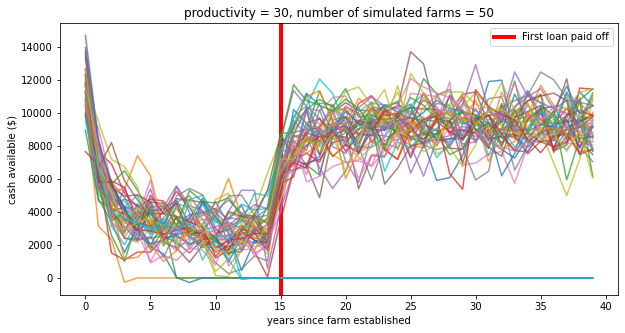

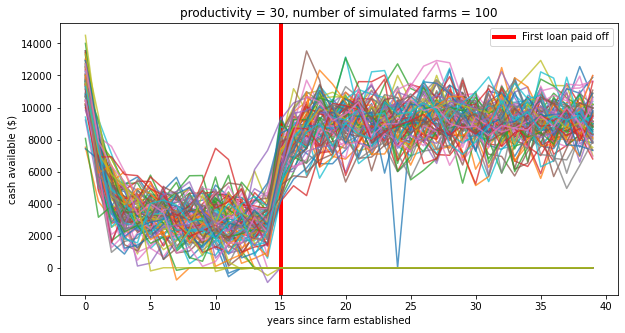

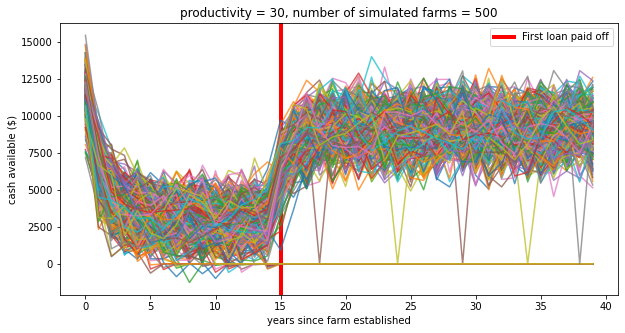

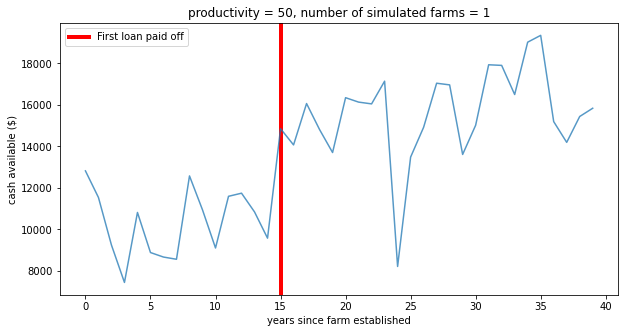

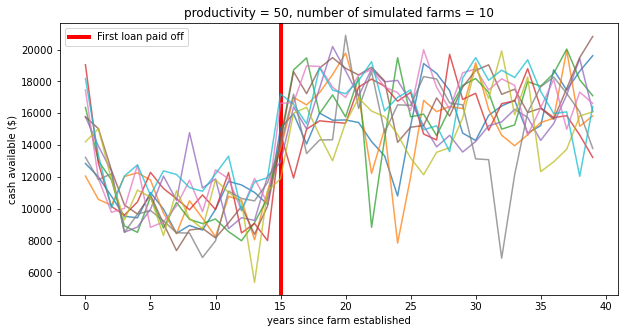

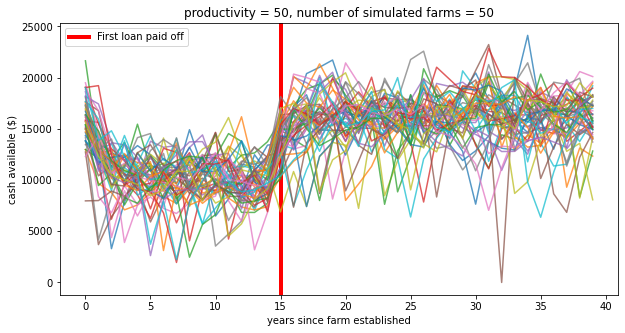

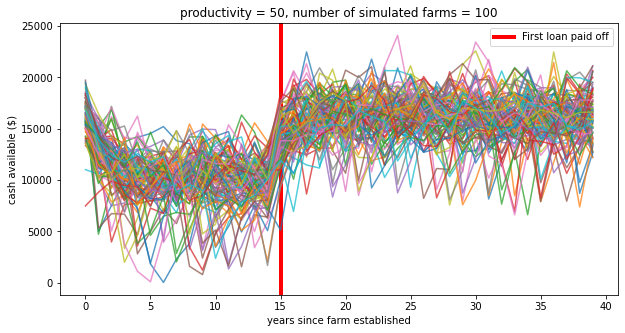

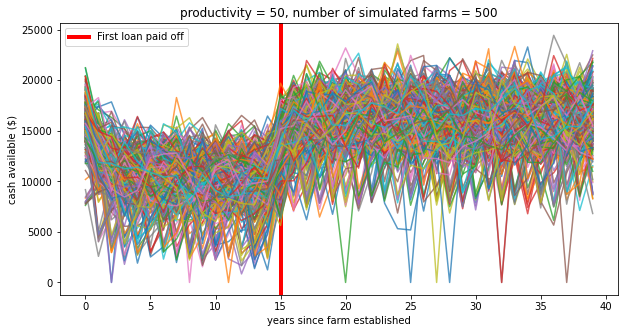

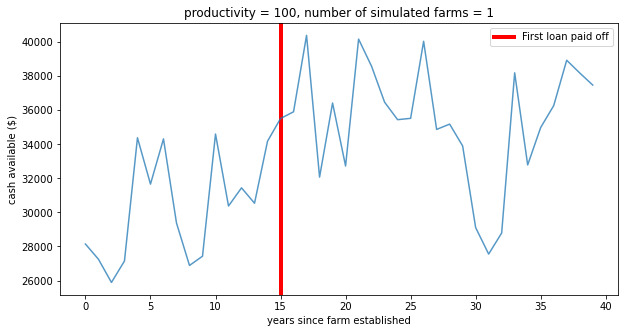

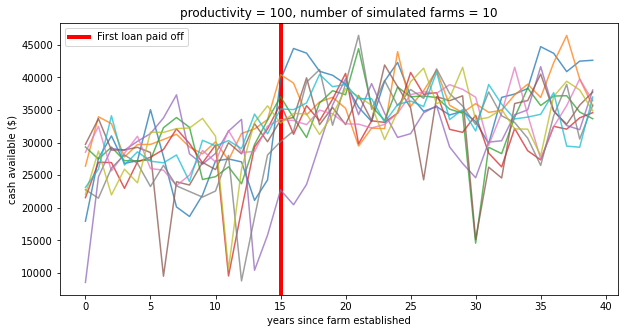

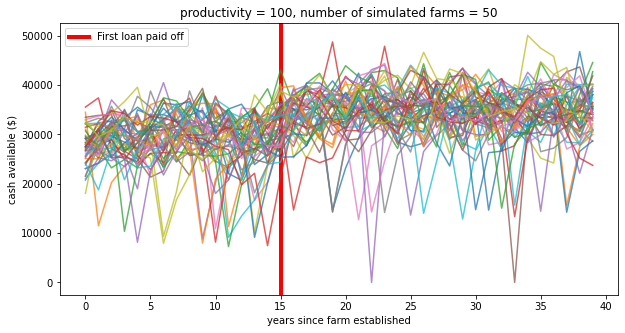

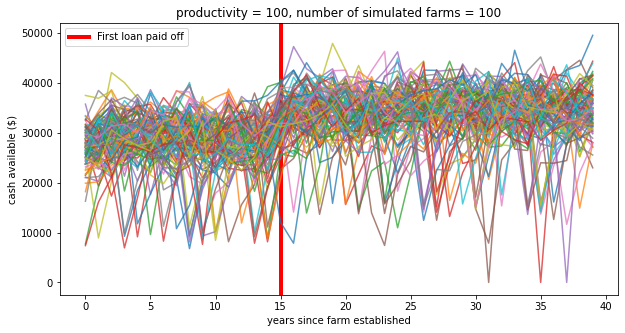

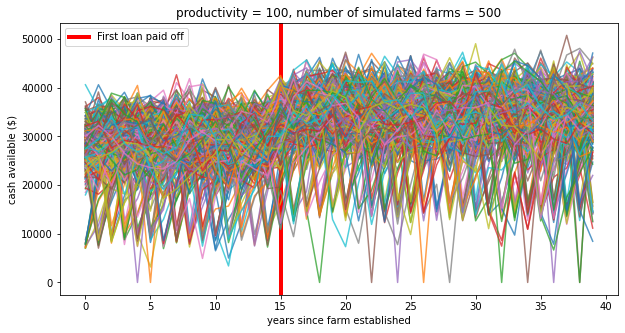

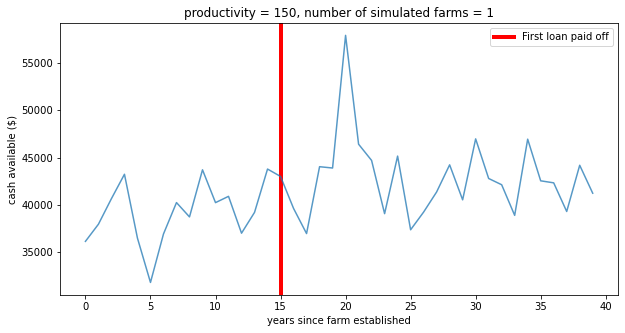

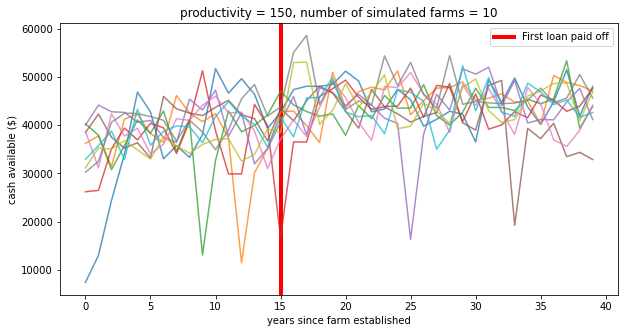

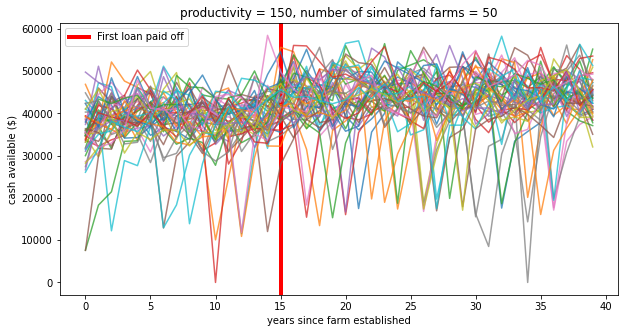

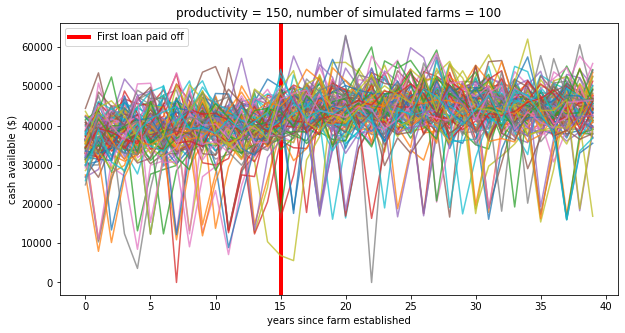

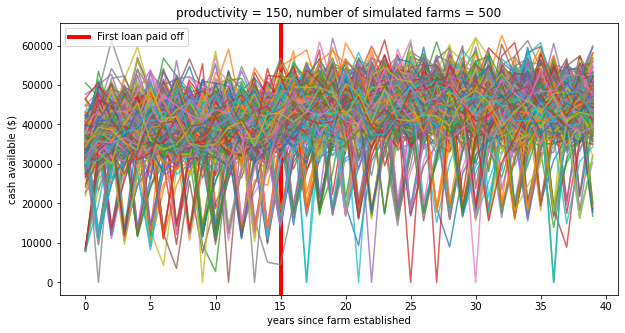

In [4]:
# We want to see how much cash would be available to a LettuceFarm over time and under various conditions 
A = [10.0, 30.0, 50.0, 100.0, 150.0]
num_simulated_farms = [1, 10, 50, 100, 500]
years = 40

for productivity in A:
    for num_farms in num_simulated_farms:
        fig, ax = plt.subplots(figsize = (10,5))
        ax.axvline(x = 15, c = 'r', lw = 4, label = 'First loan paid off')
        ax.set_title(f'productivity = {str(int(productivity))}, number of simulated farms = {str(num_farms)}')
        ax.set_xlabel('years since farm established')
        ax.set_ylabel('cash available ($)')
        ax.legend()
        for farm in range(num_farms):          
            our_farm = LettuceFarm(productivity = productivity)
            add_year_info = [our_farm.add_year() for _ in range(years)]
            profits = [year[0] for year in add_year_info] 
            cash = [year[1] for year in add_year_info]
            ax.plot(cash, alpha = 0.75)
        plt.show()

# Web scraping.

In [5]:
# We want to know the distribution of download frequencies for the Top 100 EBooks on Project Gutenberg yesterday
url = 'https://www.gutenberg.org/browse/scores/top'

# Turn the html into something we can use in Python
r = requests.get(url)
soup = bs4.BeautifulSoup(r.text, 'html.parser')

# Use SelectorGadget extension in Chrome to select what you want to scrape
# (you can also inspect the html code of the page, but that is a pain — use SelectorGadget!)
soup_top100 = soup.select('#books-last1+ ol li')

for element in soup_top100:
    print(element.getText())

Simple Sabotage Field Manual by United States. Office of Strategic Services (9536)
Frankenstein; Or, The Modern Prometheus by Mary Wollstonecraft Shelley (4148)
Pride and Prejudice by Jane Austen (2193)
The Great Gatsby by F. Scott  Fitzgerald (1881)
Et dukkehjem. English by Henrik Ibsen (1346)
The Importance of Being Earnest: A Trivial Comedy for Serious People by Oscar Wilde (1199)
A Tale of Two Cities by Charles Dickens (1138)
Alice's Adventures in Wonderland by Lewis Carroll (961)
Metamorphosis by Franz Kafka (865)
Jane Eyre: An Autobiography by Charlotte Brontë (858)
The Hound of the Baskervilles by Arthur Conan Doyle (848)
A Modest Proposal by Jonathan Swift (844)
The Picture of Dorian Gray by Oscar Wilde (835)
The Yellow Wallpaper by Charlotte Perkins Gilman (828)
The Scarlet Letter by Nathaniel Hawthorne (763)
Moby Dick; Or, The Whale by Herman Melville (754)
Heart of Darkness by Joseph Conrad (750)
The Strange Case of Dr. Jekyll and Mr. Hyde by Robert Louis Stevenson (732)
Ant

In [6]:
# Let's make a list where each element is a Top 100 EBook's information
books_downloads = [book.getText() for book in soup_top100]

# We can "unpack" and print the elements of our list nicely like this
print(*books_downloads, sep = '\n')

Simple Sabotage Field Manual by United States. Office of Strategic Services (9536)
Frankenstein; Or, The Modern Prometheus by Mary Wollstonecraft Shelley (4148)
Pride and Prejudice by Jane Austen (2193)
The Great Gatsby by F. Scott  Fitzgerald (1881)
Et dukkehjem. English by Henrik Ibsen (1346)
The Importance of Being Earnest: A Trivial Comedy for Serious People by Oscar Wilde (1199)
A Tale of Two Cities by Charles Dickens (1138)
Alice's Adventures in Wonderland by Lewis Carroll (961)
Metamorphosis by Franz Kafka (865)
Jane Eyre: An Autobiography by Charlotte Brontë (858)
The Hound of the Baskervilles by Arthur Conan Doyle (848)
A Modest Proposal by Jonathan Swift (844)
The Picture of Dorian Gray by Oscar Wilde (835)
The Yellow Wallpaper by Charlotte Perkins Gilman (828)
The Scarlet Letter by Nathaniel Hawthorne (763)
Moby Dick; Or, The Whale by Herman Melville (754)
Heart of Darkness by Joseph Conrad (750)
The Strange Case of Dr. Jekyll and Mr. Hyde by Robert Louis Stevenson (732)
Ant

In [7]:
# Let's make another list where each element is an integer of the download count of a book
download_counts = [int(string.split('(')[-1].split(')')[0]) for string in books_downloads]
print(*download_counts, sep = '\n')

9536
4148
2193
1881
1346
1199
1138
961
865
858
848
844
835
828
763
754
750
732
724
703
661
652
594
582
567
544
529
521
514
482
480
464
460
457
451
449
441
434
432
403
396
382
374
355
352
349
349
347
345
340
329
326
323
317
312
311
307
307
306
303
296
289
285
285
285
275
274
269
263
256
251
250
245
242
241
239
239
232
232
224
224
222
220
215
210
205
201
201
201
200
200
196
196
196
196
195
195
194
194
193


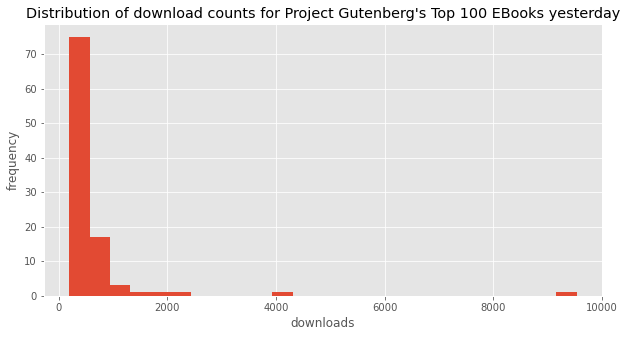

In [8]:
# Finally, let's create a histogram of download counts
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize = (10,5))
ax.set_title('Distribution of download counts for Project Gutenberg\'s Top 100 EBooks yesterday')
ax.set_xlabel('downloads')
ax.set_ylabel('frequency')
ax.hist(download_counts, bins = 25)
plt.show()

In [ ]:
# Exercise (this is a bit challenging but will definitely be good practice -- even if you just do a step or two!):
# 1. Scrape the table here: https://www.uspto.gov/web/offices/ac/ido/oeip/taf/univ/org_gr/all_univ_ag.htm
# 2. Make the table into a pandas dataframe that looks exactly the same as what you see on the site
# 3. Use information about the distribution of patents among universities to create your own ResearchUniversity class.
#    This class should have an add_year method that simulates the number of patents at a given university over time.
# 4. Plot the time series of number of patents that your simulated ResearchUniversity has in the same way we plotted
#    the cash available to our simulated LettuceFarm.
# Bonus: Figure out how to save your output along the way (as a PDF, csv, etc.)

Additional resources:

+ General python coding: https://automatetheboringstuff.com/
+ Python for economics: https://quantecon.org/